In [1]:
from __future__ import division, print_function

import os
import sys
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from redmonster.datamgr.io2 import read_ndArch
from SetCoverPy import setcover, mathutils

%matplotlib inline

In [2]:
# Plotting preferences
#import seaborn as sns
#sns.set(style='white', font_scale=1.4)
#col = sns.color_palette('dark')
mpl.rcParams.update({'font.size': 14})

In [3]:
# Initialize the random seed so the results are reproducible, below.
seed = 999
rand = np.random.RandomState(seed)

In [15]:
# Read the redmonster QSOs
tempfile = os.path.join(os.getenv('REDMONSTER_TEMPLATES_DIR'), 'ndArch-QSO-V003.fits')
flux, _, hdr = read_ndArch(tempfile)
wave = 10**(hdr['coeff0'] + np.arange(hdr['nwave']) * hdr['coeff1'])
(nspec, npix) = flux.shape
ferr = np.ones_like(flux)
cost = np.ones(nspec) # uniform cost
print(flux.shape, ferr.shape, wave.shape, nspec)

(625, 9714) (625, 9714) (9714,) 625


In [5]:
# Normalize to the median flux around 5500-5550
normflux = flux.copy()
#for ii in range(nspec):
#    ww = np.where((wave>5500)*(wave<5550))[0]
#    normflux[ii, :] /= np.median(flux[ii, ww])

[525 299  84  72 283  23 436  84 299 216 313  43 257 234 206 454 371 521
 363  78  16 447 543 302  52]


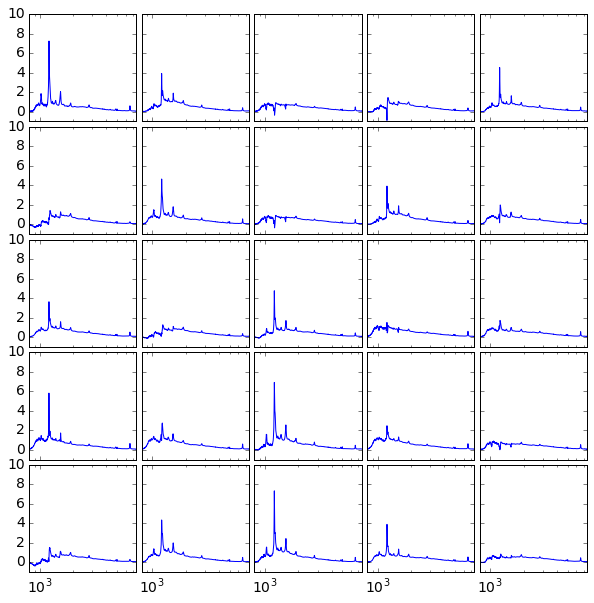

In [42]:
# Plot a random sampling of the parent spectra.
nrow, ncol = (5, 5)
nplot = nrow*ncol
these = rand.choice(nspec, nplot)
print(these)
fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
for thisax, indx in zip(ax.flat, these):
    thisax.semilogx(wave, normflux[indx, :])
    thisax.set_xlim(wave.min(), wave.max())
    thisax.set_ylim(-1, 10)
    #thisax.xaxis.set_major_locator(plt.MaxNLocator(2))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [7]:
# Compute chi2 as our "distance" matrix.
chi2 = np.zeros((nspec, nspec))
amp = np.zeros((nspec, nspec))
for ii in range(nspec):
    xx = normflux[ii, :].reshape(1, npix)
    xxerr = ferr[ii, :].reshape(1, npix)
    amp1, chi21 = mathutils.quick_amplitude(xx, normflux, xxerr, ferr)
    chi2[ii, :] = chi21
    amp[ii, :] = amp1
#chi2 /= (nspec-1.0) # reduced chi^2?!?

In [8]:
print(chi2)

[[   0.            8.26890499   33.09959113 ...,  783.40991442
   802.99935307  830.35894532]
 [   8.26847316    0.            8.10128487 ...,  767.63880697
   766.46443745  772.84491676]
 [  33.07053553    8.09995332    0.         ...,  799.60982393
   777.88039878  764.21497035]
 ..., 
 [ 563.25088354  555.7378306   577.41005204 ...,    0.            8.16512694
    32.52851   ]
 [ 572.91790136  555.05743674  566.14795974 ...,    8.16504099    0.
     8.06610323]
 [ 585.99608121  558.05181533  558.77511151 ...,   32.52526543
     8.06598759    0.        ]]


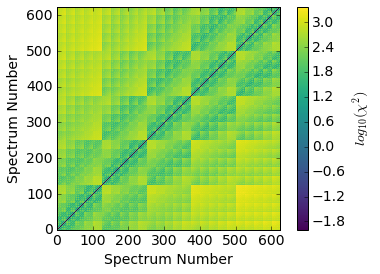

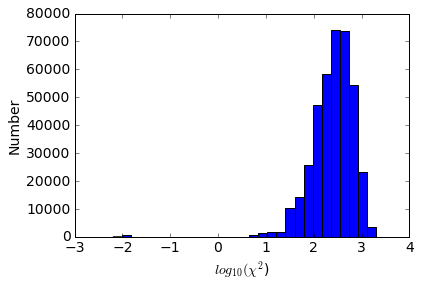

In [11]:
# Need to figure out what chi^2 minimum to choose.
_chi2 = chi2
_chi2[chi2 == 0] = 0.01
plt.figure()
plt.imshow(np.log10(_chi2), origin='lower', interpolation='nearest', 
           vmin=-2.0, cmap='viridis')
plt.xlabel('Spectrum Number')
plt.ylabel('Spectrum Number')
plt.colorbar(label='$log_{10}(\chi^{2})$')

plt.figure()
plt.hist(np.log10(_chi2).reshape(nspec*nspec), bins=30, range=(-2.2, 3.5))
plt.ylabel('Number')
plt.xlabel('$log_{10}(\chi^{2}$)')

In [12]:
# If we want the archetypes to describe each spectrum in the parent sample to a precision
# of prec=0.1 (10%) then we we should set chi2min to be approximately npix*prec^2.
prec = 0.1
chi2min = npix*prec**2
print(chi2min, np.log10(chi2min)) # seems high...

97.14 1.98739809914


In [39]:
# Messing around with some chi2min arrays...
print(np.linspace(0.1, 10, 10))
print(np.logspace(1.0, 2.0, 10))

[  0.1   1.2   2.3   3.4   4.5   5.6   6.7   7.8   8.9  10. ]
[  10.           12.91549665   16.68100537   21.5443469    27.82559402
   35.93813664   46.41588834   59.94842503   77.42636827  100.        ]


In [40]:
# Generate a plot of number of archtypes vs chi2 threshold
chi2min_grid = np.logspace(1.0, 2, 8)
narch_grid = np.zeros_like(chi2min_grid)
for ii, cmin in enumerate(chi2min_grid):
    print('Adopting chi2min = {}'.format(cmin))
    gg = setcover.SetCover((chi2 <= cmin)*1, cost)
    sol, time = gg.SolveSCP()
    narch_grid[ii] = len(np.nonzero(gg.s)[0])
    print()

Adopting chi2min = 10.0
This Best solution: UB=193.0, LB=155.427189527, UB1=207.0, LB1=155.811342385
Current Best Solution: UB=193.0, LB=155.427189527, change=19.4677774471% @ niters=0
This Best solution: UB=191.0, LB=155.563842271, UB1=204.0, LB1=155.895897648
Current Best Solution: UB=191.0, LB=155.563842271, change=18.5529621619% @ niters=5
This Best solution: UB=206.0, LB=-130.177884778, UB1=206.0, LB1=-130.177884778
Current Best Solution: UB=191.0, LB=155.51438682, change=18.578855068% @ niters=10
This Best solution: UB=191.0, LB=155.742359546, UB1=204.0, LB1=155.905794544
Current Best Solution: UB=189.0, LB=155.341204169, change=17.8088866832% @ niters=15
Iteration in re-initialization reaches maximum number = 20
Current Best Solution: UB=189.0, LB=155.341204169, change=17.8088866832% @ niters=20
Final Best solution: 189.0
Took 2.586 minutes to reach current solution.

Adopting chi2min = 13.8949549437
This Best solution: UB=157.0, LB=138.264592033, UB1=164.0, LB1=138.344061159
Cu

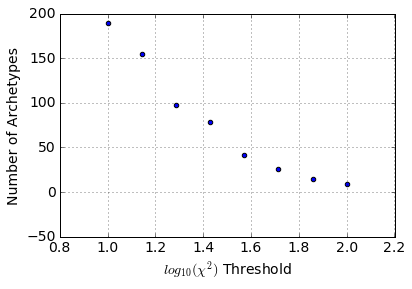

In [45]:
fig, ax = plt.subplots(1, 1)
ax.scatter(np.log10(chi2min_grid), narch_grid)
#ax.semilogx(chi2min, narch, '-o')
ax.set_xlabel('$log_{10}(\chi^{2})$ Threshold')
ax.set_ylabel('Number of Archetypes')
ax.grid(True)

In [13]:
# Function to get the responsibility for a given set of archetypes.
def responsibility(iarch, a_matrix):
    '''
    Args
      iarch : indices of the archetypes
      a_matrix : distance matrix
    Returns 
      resp : responsibility of each archetype (number of objects represented by each archetype)
      respindx : list containing the indices of the parent objects represented by each archetype
    '''
    narch = len(iarch)
    resp = np.zeros(narch).astype('int16')
    respindx = []
    for ii, this in enumerate(iarch):
        respindx.append(np.where(a_matrix[:, this] == 1)[0])
        resp[ii] = np.count_nonzero(a_matrix[:, this])
    return resp, respindx

In [46]:
# Solve the SCP given the preceding results.  Also get the responsibility.
chi2min = 10**1.5
a_matrix = (chi2 <= chi2min)*1
gg = setcover.SetCover(a_matrix, cost)
sol, time = gg.SolveSCP()

This Best solution: UB=68.0, LB=-241.079222166, UB1=68.0, LB1=-241.079222166
Current Best Solution: UB=68.0, LB=-241.079222166, change=454.528267892% @ niters=0
This Best solution: UB=59.0, LB=50.6938194345, UB1=64.0, LB1=50.7036936584
Current Best Solution: UB=59.0, LB=50.6938194345, change=14.078272145% @ niters=5
This Best solution: UB=72.0, LB=-1998.43737534, UB1=72.0, LB1=-1998.43737534
Current Best Solution: UB=58.0, LB=50.6103598025, change=12.7407589612% @ niters=10
This Best solution: UB=60.0, LB=50.5434423383, UB1=63.0, LB1=50.5467105902
Current Best Solution: UB=58.0, LB=50.6103598025, change=12.7407589612% @ niters=15
Iteration in re-initialization reaches maximum number = 20
Current Best Solution: UB=58.0, LB=50.6103598025, change=12.7407589612% @ niters=20
Final Best solution: 58.0
Took 1.443 minutes to reach current solution.


In [47]:
# Get the indices of the archetypes.
iarch = np.nonzero(gg.s)[0]
nnarch = len(iarch)
resp, respindx = responsibility(iarch, a_matrix)
print(time, sol, iarch, resp, np.sum(resp)) # sum(resp)>nspec!

1.44299743176 58.0 [ 11  13  29  35  43  60  61  62  75  78  88 111 136 138 150 154 161 163
 186 193 203 216 231 238 253 260 263 271 285 293 304 315 316 318 325 343
 358 366 385 387 412 414 436 438 453 459 460 468 487 496 501 514 528 535
 550 558 581 606] [16 15  9 14 16 15 21 23 11 15 23 20 14 14  8  9 16 16 17 17 14 18 14 16 13
 13 17  8 15 15  9 12 16 16 12 18 13 12 16 24 25 16 28 27 23 18 22 21 20 11
 10 15 11 15  8 16 17 18] 921


In [48]:
print(respindx[2])

[ 4 27 28 29 33 34 39 54 59]


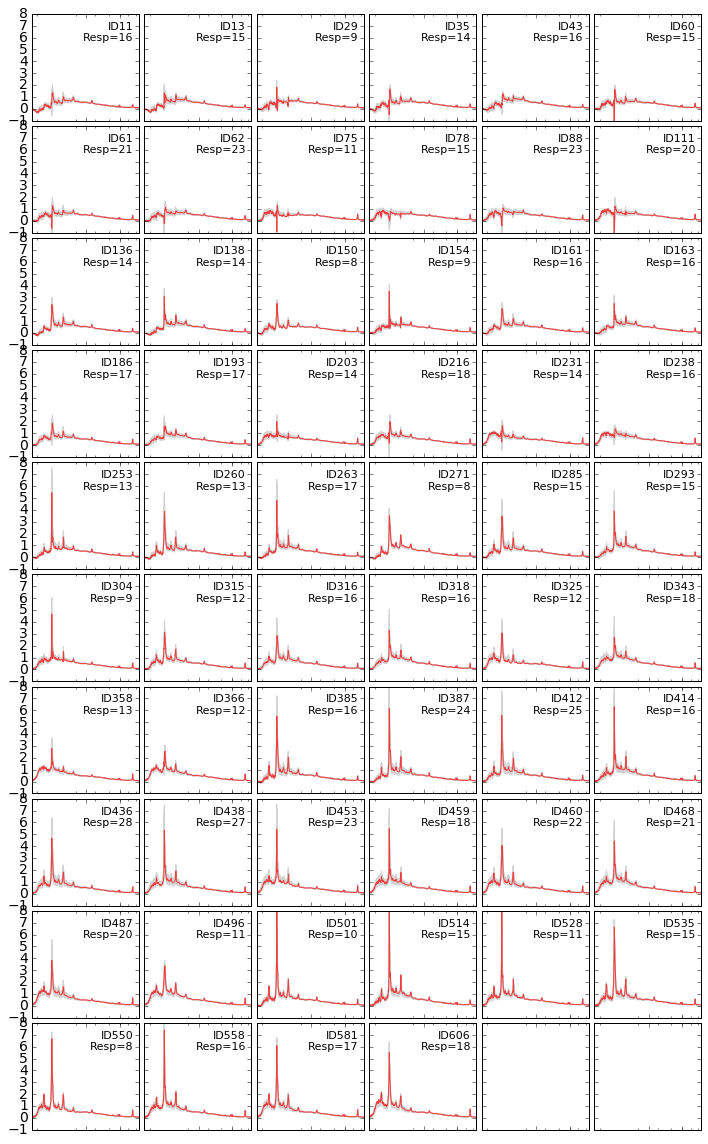

In [51]:
# Plot the archetypes. 
nrow, ncol = (10, 6)
nplot = nrow*ncol
fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow), sharey=True, sharex=True)
for thisax, indx, rindx, rr in zip(ax.flat, iarch, respindx, resp):
    for ii in rindx:
        thisax.semilogx(wave, normflux[ii, :], color='lightgray')
    thisax.semilogx(wave, normflux[indx, :], alpha=0.7, color='red')
    thisax.set_xlim(wave.min(), wave.max())
    thisax.set_ylim(-1, 8)
    thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
    thisax.text(0.95, 0.93, 'ID{:02d}\nResp={}'.format(indx, rr), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
fig.subplots_adjust(wspace=0.05, hspace=0.05)